In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11977636.94it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 196571.27it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3692353.41it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22237154.47it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

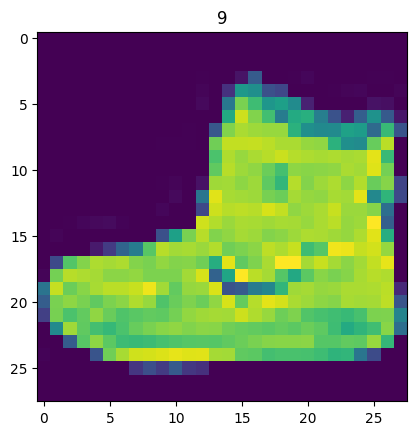

In [3]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

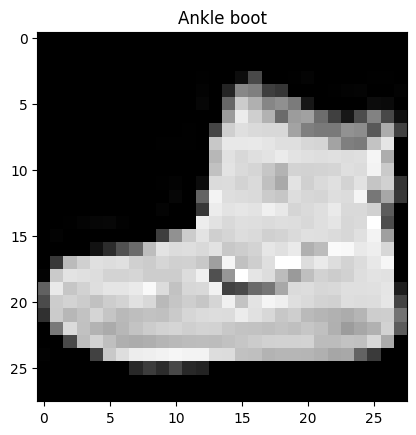

In [5]:
class_names = train_data.classes
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

### Prep Data loader

In [6]:
from torch.utils.data import DataLoader

In [8]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### Model 0

In [10]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [11]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=784 * 2, output_shape=len(class_names))

In [12]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [13]:
from tqdm.auto import tqdm

In [14]:
torch.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:06<00:12,  6.21s/it]


Train loss: 0.55910 | Test loss: 0.50156, Test acc: 82.64%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:12<00:06,  6.17s/it]


Train loss: 0.47335 | Test loss: 0.48532, Test acc: 82.89%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:18<00:00,  6.14s/it]


Train loss: 0.45419 | Test loss: 0.47610, Test acc: 83.54%



In [15]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               accuracy_fn):
    
    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        loss /= len(data_loader)
        acc /= len(data_loader)

        return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [16]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4761044383049011,
 'model_acc': 83.53634185303514}

In [29]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [33]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
    hidden_units=784 * 2,
    output_shape=len(class_names)
)

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [21]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


In [22]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in data_loader:
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [35]:
torch.manual_seed(42)

epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoc: {epoch}")

    train_step(data_loader=train_dataloader,
               model=model_1,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    
    test_step(data_loader=test_dataloader,
               model=model_1,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoc: 0
Train loss: 2.16099 | Train accuracy: 28.86%


  5%|▌         | 1/20 [00:40<12:43, 40.19s/it]

Test loss: 1.64060 | Test accuracy: 37.01%

Epoc: 1
Train loss: 1.47247 | Train accuracy: 41.10%


 10%|█         | 2/20 [01:19<11:51, 39.55s/it]

Test loss: 1.40561 | Test accuracy: 44.07%

Epoc: 2
Train loss: 1.24492 | Train accuracy: 50.39%


 15%|█▌        | 3/20 [01:58<11:09, 39.40s/it]

Test loss: 1.19350 | Test accuracy: 52.67%

Epoc: 3
Train loss: 1.11916 | Train accuracy: 55.05%


 20%|██        | 4/20 [02:37<10:30, 39.41s/it]

Test loss: 1.11706 | Test accuracy: 55.17%

Epoc: 4
Train loss: 1.07466 | Train accuracy: 56.44%


 25%|██▌       | 5/20 [03:17<09:50, 39.38s/it]

Test loss: 1.10348 | Test accuracy: 55.22%

Epoc: 5
Train loss: 1.04346 | Train accuracy: 57.52%


 30%|███       | 6/20 [03:56<09:09, 39.25s/it]

Test loss: 1.05870 | Test accuracy: 56.89%

Epoc: 6
Train loss: 1.02031 | Train accuracy: 58.26%


 35%|███▌      | 7/20 [04:35<08:28, 39.12s/it]

Test loss: 1.04603 | Test accuracy: 57.63%

Epoc: 7
Train loss: 1.00479 | Train accuracy: 58.67%


 40%|████      | 8/20 [05:14<07:50, 39.18s/it]

Test loss: 1.03065 | Test accuracy: 57.81%

Epoc: 8
Train loss: 0.98960 | Train accuracy: 59.20%


 45%|████▌     | 9/20 [05:53<07:11, 39.22s/it]

Test loss: 1.02675 | Test accuracy: 58.25%

Epoc: 9
Train loss: 0.97803 | Train accuracy: 59.65%


 50%|█████     | 10/20 [06:32<06:31, 39.16s/it]

Test loss: 1.01320 | Test accuracy: 58.54%

Epoc: 10
Train loss: 0.96748 | Train accuracy: 60.06%


 55%|█████▌    | 11/20 [07:11<05:50, 38.98s/it]

Test loss: 1.00837 | Test accuracy: 58.67%

Epoc: 11
Train loss: 0.95701 | Train accuracy: 60.32%


 60%|██████    | 12/20 [07:49<05:11, 38.88s/it]

Test loss: 1.00230 | Test accuracy: 58.64%

Epoc: 12
Train loss: 0.94755 | Train accuracy: 60.67%


 65%|██████▌   | 13/20 [08:28<04:31, 38.78s/it]

Test loss: 0.99917 | Test accuracy: 58.82%

Epoc: 13
Train loss: 0.94026 | Train accuracy: 60.90%


 70%|███████   | 14/20 [09:07<03:52, 38.74s/it]

Test loss: 1.00285 | Test accuracy: 59.05%

Epoc: 14
Train loss: 0.93302 | Train accuracy: 61.17%


 75%|███████▌  | 15/20 [09:45<03:13, 38.69s/it]

Test loss: 0.99995 | Test accuracy: 58.91%

Epoc: 15
Train loss: 0.92652 | Train accuracy: 61.40%


 80%|████████  | 16/20 [10:24<02:34, 38.63s/it]

Test loss: 0.98391 | Test accuracy: 59.50%

Epoc: 16
Train loss: 0.91778 | Train accuracy: 61.67%


 85%|████████▌ | 17/20 [11:03<01:56, 38.72s/it]

Test loss: 1.00230 | Test accuracy: 58.64%

Epoc: 17
Train loss: 0.91184 | Train accuracy: 61.89%


 90%|█████████ | 18/20 [11:41<01:17, 38.70s/it]

Test loss: 1.00405 | Test accuracy: 58.66%

Epoc: 18
Train loss: 0.90390 | Train accuracy: 62.23%


 95%|█████████▌| 19/20 [12:20<00:38, 38.64s/it]

Test loss: 1.02530 | Test accuracy: 57.87%

Epoc: 19
Train loss: 0.89746 | Train accuracy: 62.46%


100%|██████████| 20/20 [12:58<00:00, 38.94s/it]

Test loss: 1.00500 | Test accuracy: 58.67%



In [37]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x:torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x
    



In [38]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [43]:
torch.manual_seed(42)

epochs = 3
for epoch in tqdm(range(epochs)):
    train_step(data_loader=train_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.29765 | Train accuracy: 89.37%


 33%|███▎      | 1/3 [00:10<00:20, 10.08s/it]

Test loss: 0.31485 | Test accuracy: 88.87%

Train loss: 0.28759 | Train accuracy: 89.58%


 67%|██████▋   | 2/3 [00:20<00:10, 10.06s/it]

Test loss: 0.31550 | Test accuracy: 88.53%

Train loss: 0.27834 | Train accuracy: 89.94%


100%|██████████| 3/3 [00:30<00:00, 10.06s/it]

Test loss: 0.29860 | Test accuracy: 89.48%



In [42]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3099040985107422,
 'model_acc': 88.7679712460064}

In [44]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob)

    return torch.stack(pred_probs)

In [45]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [46]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[4.3208e-10, 3.0375e-11, 1.3321e-10, 2.6577e-12, 2.3479e-12, 1.0000e+00,
         2.2817e-09, 1.0026e-08, 4.3232e-07, 2.9165e-07],
        [4.0284e-02, 8.1143e-01, 1.6205e-03, 1.5226e-02, 8.2128e-02, 2.7713e-05,
         4.8932e-02, 6.6945e-05, 3.1182e-05, 2.5248e-04]])

In [47]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[4.3208e-10, 3.0375e-11, 1.3321e-10, 2.6577e-12, 2.3479e-12, 1.0000e+00,
         2.2817e-09, 1.0026e-08, 4.3232e-07, 2.9165e-07],
        [4.0284e-02, 8.1143e-01, 1.6205e-03, 1.5226e-02, 8.2128e-02, 2.7713e-05,
         4.8932e-02, 6.6945e-05, 3.1182e-05, 2.5248e-04]])

In [48]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

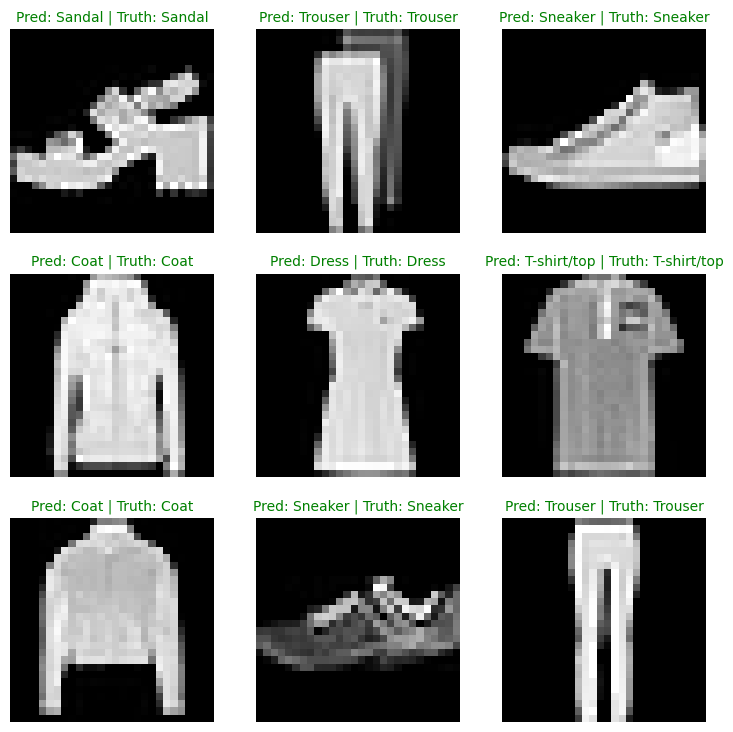

In [49]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [54]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:00<00:00, 391.19it/s]


In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

In [51]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.0


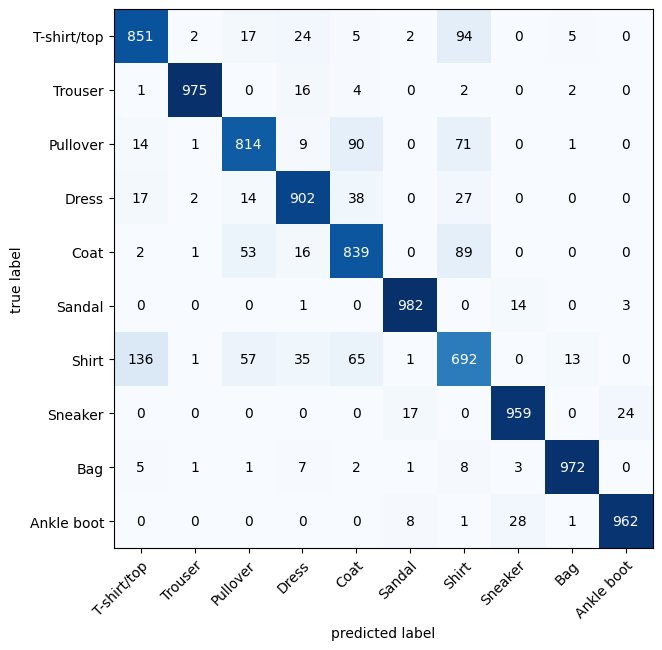

In [55]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [56]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth
